<a href="https://colab.research.google.com/github/ShekSingh/AlgorithmsPartOne/blob/master/Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


N = 1000
np.random.seed(1)
id = np.random.choice(range(1, 11), N)
purchaseday = np.random.choice(range(1, 366), N)
purchasedate = []

months = [0,31,59,90,120,151,181,212,243,273,304,334]

def makedate(x):
    month = max([i for i in range(len(months)) if x > months[i]])
    if month > 0:
        day = x - months[month]
    else:
        day = x
    return pd.to_datetime("2022-"+str(month+1)+"-"+str(day))

for i in range(N):
    purchasedate.append(makedate(purchaseday[i]))




In [4]:
dat = pd.DataFrame({'id': id, 'purchasedate': purchasedate})
dat2 = dat.sort_values(['id', 'purchasedate'])
dat2['datediff'] = np.zeros(N)
dat2['salecat'] = np.empty(N, dtype='str')


for i in range(1, 11):
    dat2i = dat2[dat2['id']==i]
    datediff = np.diff(dat2i['purchasedate'])
    salecat = np.where(datediff <= pd.Timedelta(days=2), 'daily',
                       np.where(datediff <= pd.Timedelta(days=9), 'weekly',
                                np.where(datediff <= pd.Timedelta(days=17), 'biweekly', 'monthly')))
    dat2.loc[dat2['id']==i, 'datediff'] = np.concatenate(([0], pd.Series(datediff).dt.days))
    dat2.loc[dat2['id']==i, 'salecat'] = np.concatenate((['new'], salecat))





In [5]:
dat2.head()

,id,purchasedate,datediff,salecat
519,1,2022-01-01,0.0,new
177,1,2022-01-03,2.0,daily
251,1,2022-01-17,14.0,biweekly
173,1,2022-01-18,1.0,daily
245,1,2022-01-18,0.0,daily


In [6]:
dat2.shape

(1000, 4)

In [7]:
dat2[dat2.id == 2].shape

(92, 4)

In [8]:
freqcounts = pd.DataFrame({'id': range(1, 11),
                           'daily': [np.sum(dat2.loc[dat2['id']==i, 'salecat']=='daily') for i in range(1, 11)],
                           'weekly': [np.sum(dat2.loc[dat2['id']==i, 'salecat']=='weekly') for i in range(1, 11)],
                           'biweekly': [np.sum(dat2.loc[dat2['id']==i, 'salecat']=='biweekly') for i in range(1, 11)],
                           'monthly': [np.sum(dat2.loc[dat2['id']==i, 'salecat']=='monthly') for i in range(1, 11)]})





In [9]:
alpha = np.ones(4)  # hyperparameter for the Dirichlet distribution


In [18]:
i = 1  # customer number

# Prior distribution: Dir(alpha1 = 1, alpha2 = 1,...)
# Posterior dist      Dir(alpha1 = 1+37, alpha2 = 1+52)

print(alpha.shape)


(4,)


In [19]:
print(freqcounts.iloc[i,1:4].shape)

(3,)


In [21]:
freqcounts.iloc[i,1:5].head()

daily       42
weekly      41
biweekly     7
monthly      1
Name: 1, dtype: int64

In [22]:
freqcounts.shape

(10, 5)

In [23]:

prop_post = stats.dirichlet.rvs(size=1000, alpha=alpha+freqcounts.iloc[i,1:5])  # 1000 samples from the posterior distribution


In [28]:
prop_post.shape

(1000, 4)

In [34]:
freqcounts.iloc[i,1:5].head()

daily       42
weekly      41
biweekly     7
monthly      1
Name: 1, dtype: int64

<Axes: >

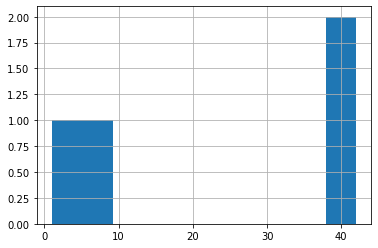

In [32]:
freqcounts.iloc[i,1:5].hist()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

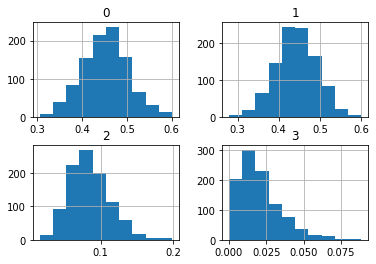

In [31]:
pd.DataFrame(prop_post).hist()

In [24]:






# Cumulative probabilities
prop_post_cumul = np.zeros((1000, 3))
prop_post_cumul[:, 0] = prop_post[:, 0]  # first column is Daily group only
prop_post_cumul[:, 1] = prop_post[:, 0] + prop_post[:, 1]  # second column is Daily group + Weekly group
prop_post_cumul[:, 2] = prop_post[:, 0] + prop_post[:, 1] + prop_post[:, 2]  # Third column is Daily + Weekly + Biweekly







In [35]:
prop_post_cumul

array([[0.47502877, 0.93605336, 0.98764224],
       [0.49381873, 0.89701259, 0.99648471],
       [0.47951256, 0.92020109, 0.97161671],
       ...,
       [0.39062988, 0.91691002, 0.99673213],
       [0.4297441 , 0.89778131, 0.99221675],
       [0.46456715, 0.8940505 , 0.99535741]])

In [25]:
  # credible sets for each individual group
np.apply_along_axis(lambda x: np.quantile(x, q=[0.025, 0.975]), axis=0, arr=prop_post)

array([[0.35354091, 0.34515196, 0.0384965 , 0.00290939],
       [0.55442388, 0.53920717, 0.14381009, 0.05553169]])

In [37]:
c_set_prob = np.apply_along_axis(lambda x: np.quantile(x, q=[0.025, 0.975]), axis=0, arr=prop_post)

In [43]:
c_set_prob[0,:].sum()

0.7400987652389807

In [26]:
np.apply_along_axis(lambda x: np.quantile(x, q=[0.025, 0.975]), axis=0, arr=prop_post_cumul)  # credible sets for cumulative probabilities

array([[0.35354091, 0.82702052, 0.94446831],
       [0.55442388, 0.94607442, 0.99709061]])

In [ ]:
# I suggest looking at the lower end of the credible set from the cumulative probabilities
# Just make sure to order the columns in increasing order from least time (day) to most time (month)

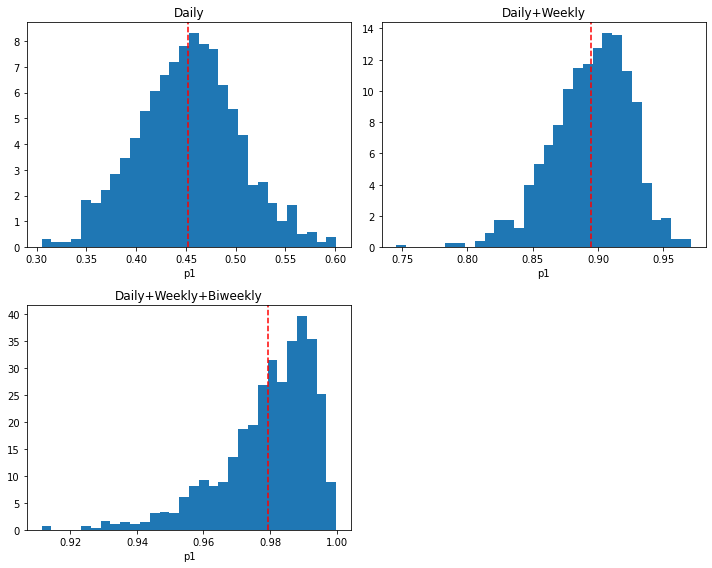

In [27]:
# Histograms of cumulative probabilities
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.hist(prop_post_cumul[:, 0], bins=30, density=True)
plt.xlabel('p1')
plt.title('Daily')
plt.axvline(x=np.mean(prop_post_cumul[:, 0]), color='r', linestyle='--')
plt.subplot(2, 2, 2)
plt.hist(prop_post_cumul[:, 1], bins=30, density=True)
plt.xlabel('p1')
plt.title('Daily+Weekly')
plt.axvline(x=np.mean(prop_post_cumul[:, 1]), color='r', linestyle='--')
plt.subplot(2, 2, 3)
plt.hist(prop_post_cumul[:, 2], bins=30, density=True)
plt.xlabel('p1')
plt.title('Daily+Weekly+Biweekly')
plt.axvline(x=np.mean(prop_post_cumul[:, 2]), color='r', linestyle='--')
plt.tight_layout()
plt.show()
